In [3]:
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
tabla = pd.read_csv("https://gitlab.com/dgtic5/res/-/raw/main/aprendizajeSupervizado/column_3C_weka.csv")
tabla

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,Normal


In [5]:
# Separar etiquetas de variables predictoras
X = tabla.drop('class', axis=1)
y = tabla['class']

In [6]:
# Separación de conjuntos
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

## Modelo: Arbol de decisión

In [7]:
# Definición (prueba con hiperparámetro genérico) y entrenamiento
modelo = DecisionTreeClassifier(max_depth = 3)
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [8]:
# Predicción inicial
y_pred = modelo.predict(X_test)

## Optimización de parámetros

In [13]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
# Espacio de búsqueda de hiperparámetros
cuadricula_parametros = [{
    'min_samples_split' : [2,4,6,8,10],
    'min_samples_leaf' : [2,4,6,8,10],
    "criterion" : ["gini","entropy","log_loss"],
    'class_weight' : ["balanced", None]
}]

In [24]:
# Optimización
buscadorCuadricula = RandomizedSearchCV(DecisionTreeClassifier(),cuadricula_parametros,
                                        cv=5,scoring="accuracy")
buscadorCuadricula.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions=[{'class_weight': ['balanced', None],
                                         'criterion': ['gini', 'entropy',
                                                       'log_loss'],
                                         'min_samples_leaf': [2, 4, 6, 8, 10],
                                         'min_samples_split': [2, 4, 6, 8,
                                                               10]}],
                   scoring='accuracy')

In [25]:
buscadorCuadricula.best_params_

{'min_samples_split': 6,
 'min_samples_leaf': 10,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [27]:
# Crear modelo con los hiperparámetros óptimos
modelo = DecisionTreeClassifier(**buscadorCuadricula.best_params_)
modelo.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=10, min_samples_split=6)

## Analizar e interpretar el árbol con parámetros optimizados

In [28]:
# Obtener predicciones
y_pred = modelo.predict(X_test)

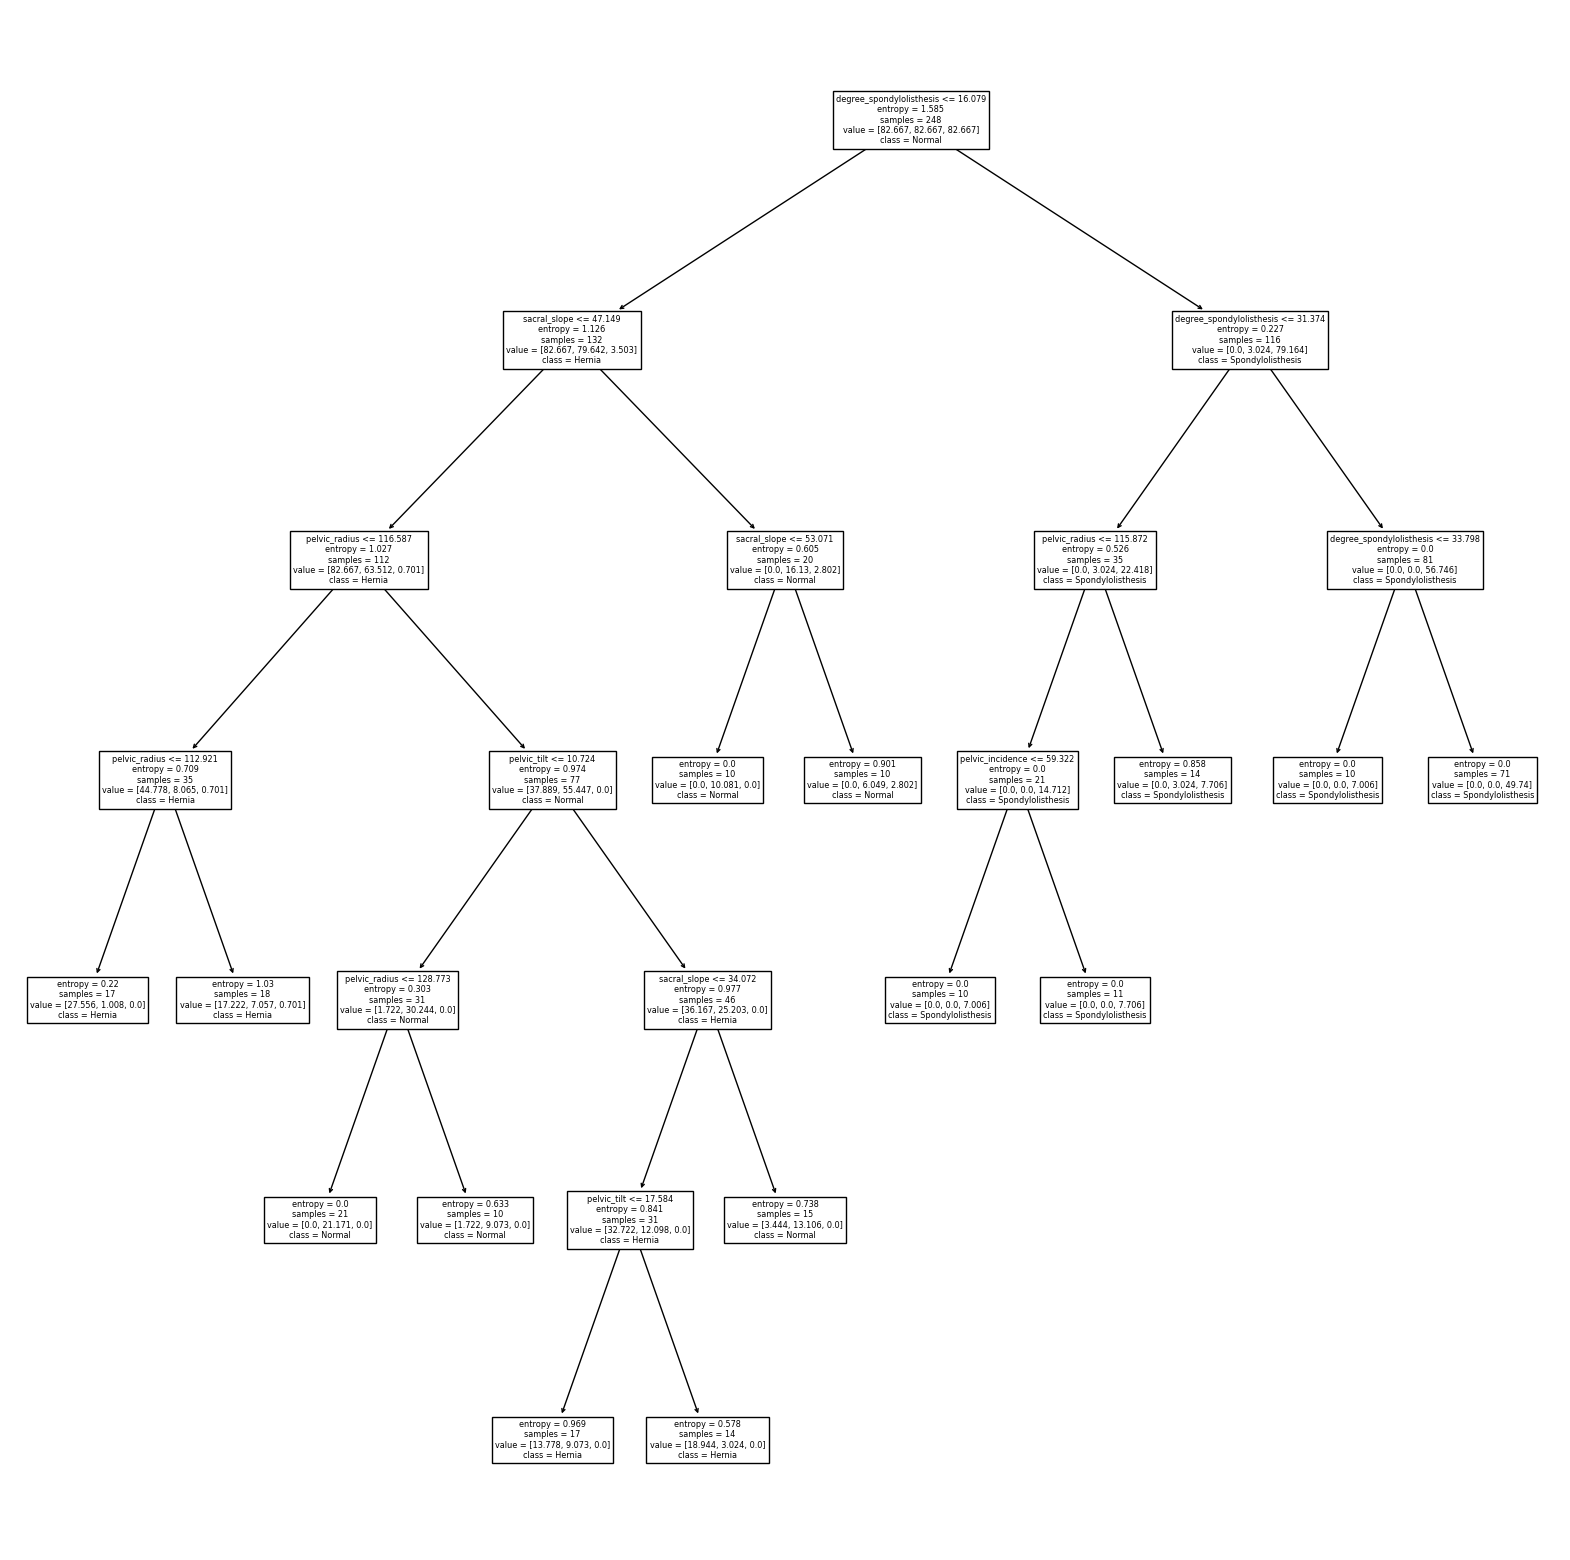

In [43]:
# Visualización del árbol
fig, ax = plt.subplots(figsize=(20,20))
plot_tree(modelo, feature_names=modelo.feature_names_in_, class_names=modelo.classes_, ax=ax);

In [46]:
print(modelo.feature_importances_)
print(modelo.feature_names_in_)

[8.40428105e-17 8.33728922e-02 0.00000000e+00 1.31192319e-01
 1.20143403e-01 6.65291387e-01]
['pelvic_incidence' 'pelvic_tilt' 'lumbar_lordosis_angle' 'sacral_slope'
 'pelvic_radius' 'degree_spondylolisthesis']


Según el modelo con los hiperparámetros optimizados, la característica más importante es la del `degree_spondylolisthesis`, y la menos importante es la de `lumbar_lordosis_angle`.

Respecto al árbol como primer criterio se toma el `degree_spondylolisthesis` si su valor es menor que 16.079 se clasifica como "Normal" el trastorno de columna; de otro modo se baja en la rama a evaluar los criterios `scaral_slope` y un rango distinto para `degree_spondylolisthesis`. De este modo se decide una clasificación con base en criterios más detallados.

El criterio de decisión se definió como "entropy" que es la entropía de Shanon para la ganancia de información.

## Obtener e interpretar la evaluación del modelo

In [47]:
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

           Hernia       0.60      0.75      0.67        12
           Normal       0.80      0.67      0.73        18
Spondylolisthesis       1.00      1.00      1.00        32

         accuracy                           0.85        62
        macro avg       0.80      0.81      0.80        62
     weighted avg       0.86      0.85      0.86        62



In [51]:
print(buscadorCuadricula.best_score_)
pd.DataFrame(buscadorCuadricula.cv_results_)

0.7986938775510204


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_criterion,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006777,0.000957,0.005007,0.001994,6,10,entropy,balanced,"{'min_samples_split': 6, 'min_samples_leaf': 1...",0.80,0.82,0.70,0.836735,0.836735,0.798694,0.051167,1
1,0.006010,0.000504,0.003574,0.000389,6,10,log_loss,balanced,"{'min_samples_split': 6, 'min_samples_leaf': 1...",0.78,0.82,0.70,0.836735,0.836735,0.794694,0.051688,2
2,0.005734,0.000293,0.003256,0.000110,2,4,log_loss,balanced,"{'min_samples_split': 2, 'min_samples_leaf': 4...",0.76,0.80,0.76,0.755102,0.836735,0.782367,0.031657,6
3,0.005357,0.000137,0.003144,0.000230,4,8,entropy,balanced,"{'min_samples_split': 4, 'min_samples_leaf': 8...",0.76,0.82,0.76,0.795918,0.836735,0.794531,0.031037,3
4,0.005555,0.000804,0.002921,0.000077,10,8,gini,balanced,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.74,0.82,0.74,0.795918,0.836735,0.786531,0.040147,5
5,0.004250,0.000073,0.003368,0.000796,4,6,gini,None,"{'min_samples_split': 4, 'min_samples_leaf': 6...",0.74,0.80,0.72,0.775510,0.795918,0.766286,0.031411,10
6,0.003595,0.000940,0.002443,0.000735,6,4,gini,None,"{'min_samples_split': 6, 'min_samples_leaf': 4...",0.72,0.82,0.72,0.795918,0.816327,0.774449,0.045208,7
7,0.002908,0.000381,0.001897,0.000124,10,8,gini,None,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.70,0.80,0.72,0.816327,0.795918,0.766449,0.047021,9
8,0.004012,0.000708,0.002089,0.000284,6,4,log_loss,balanced,"{'min_samples_split': 6, 'min_samples_leaf': 4...",0.76,0.80,0.72,0.755102,0.836735,0.774367,0.040200,8
9,0.003495,0.000478,0.001793,0.000097,2,8,log_loss,balanced,"{'min_samples_split': 2, 'min_samples_leaf': 8...",0.76,0.82,0.76,0.795918,0.836735,0.794531,0.031037,3


Se obtuve un accuracy del `0.85`, es decir que se clasificó correctamente el 85% de las muestras en el test, el mayor score medio obtenido fue de `~0.80`. Este resultado fue menor al que se encontró usando Cross Validation y Regresión logística, por lo que es probable que el desempeño de el árbol de decisión no sea mejor en este caso.

También hay que notar que en el RandomizedSearchCV no se introdujeron distribuciones, sino listas, por lo que podría mejorar la búsqueda de hiperparámetros con una distribución del espacio distinta.